In [52]:
import dac
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

import utils


from audiotools import AudioSignal
from IPython.display import Audio, display, Javascript, HTML

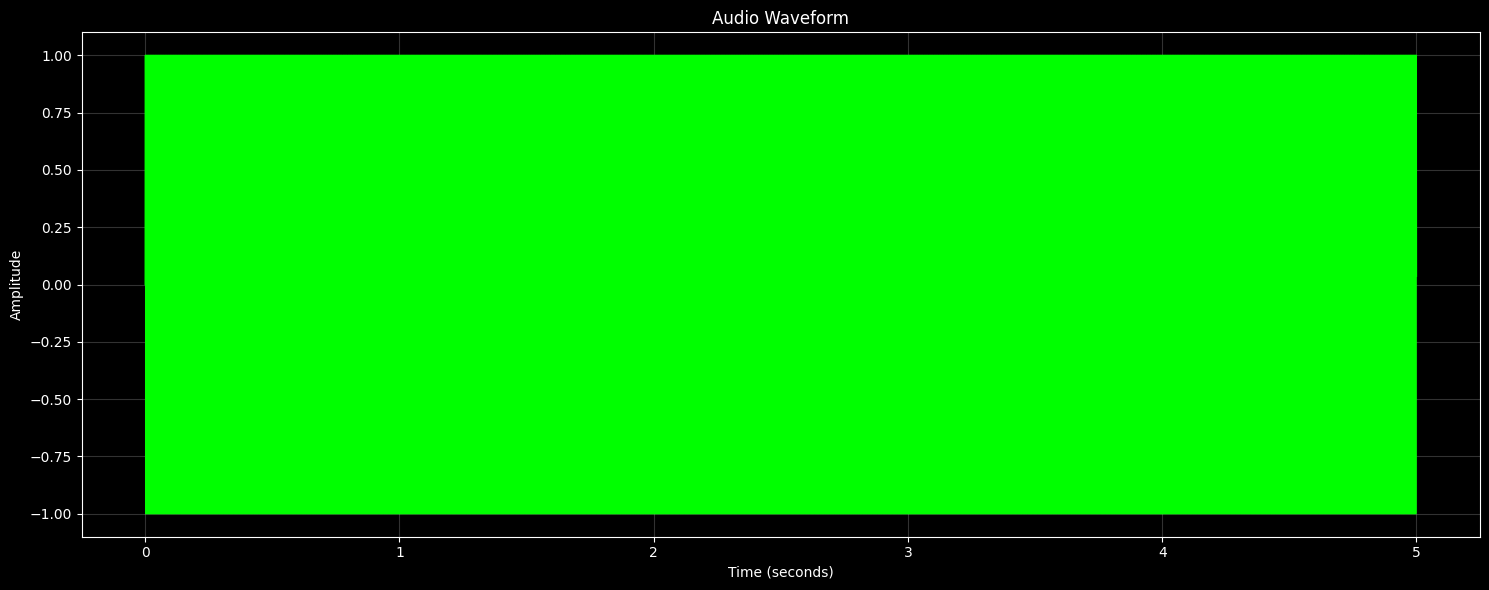

In [102]:
sr = 44100

audio = utils.sine_sweep(511, 511, 5, sr)
# noise = np.random.normal(0, 0.1, len(audio))
# audio += noise
audio = torch.tensor(audio).float()


display(Audio(audio, rate=sr))

utils.plot_waveform(audio, sr)

In [103]:
device = torch.device('cpu') # or 'cuda'

model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)
model.to(device);
model.eval();

/home/inspektral/miniconda3/envs/dacformer/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [104]:
result = utils.encode_and_decode(model, audio, sr, device)

num_samples = min(len(audio), len(result))

error = torch.mean((audio[:num_samples] - result[:num_samples]) ** 2).item()
print(f"Mean Squared Error: {error}")

display(Audio(result, rate=sr))

Mean Squared Error: 0.029410097748041153


In [105]:
len(result)/431

512.0

In [106]:

snd = AudioSignal(audio,  sample_rate=sr)

snd.to(model.device)
snd_x = model.preprocess(snd.audio_data, snd.sample_rate)

with torch.no_grad():
    snd_z, snd_codes, snd_latents, _, _ = model.encode(snd_x)

In [107]:
print(snd_latents.shape)
print(snd_latents)

torch.Size([1, 72, 431])
tensor([[[10.3204,  8.0408,  5.9289,  ..., -0.5265,  0.4564, -1.6030],
         [ 4.0246,  9.4611, 11.8803,  ..., 18.0854, 15.7699, 13.5850],
         [ 2.6921,  2.7268,  2.2525,  ...,  1.7438,  2.4583, -0.8232],
         ...,
         [-2.0977,  2.1047,  1.7251,  ..., -2.7138, -2.4888, -0.7132],
         [-2.8545, -0.5645, -0.2536,  ...,  2.0159,  2.8960, -1.7085],
         [-0.5307, -2.5714, -1.9244,  ..., -0.6952, -1.0942, -2.4317]]])


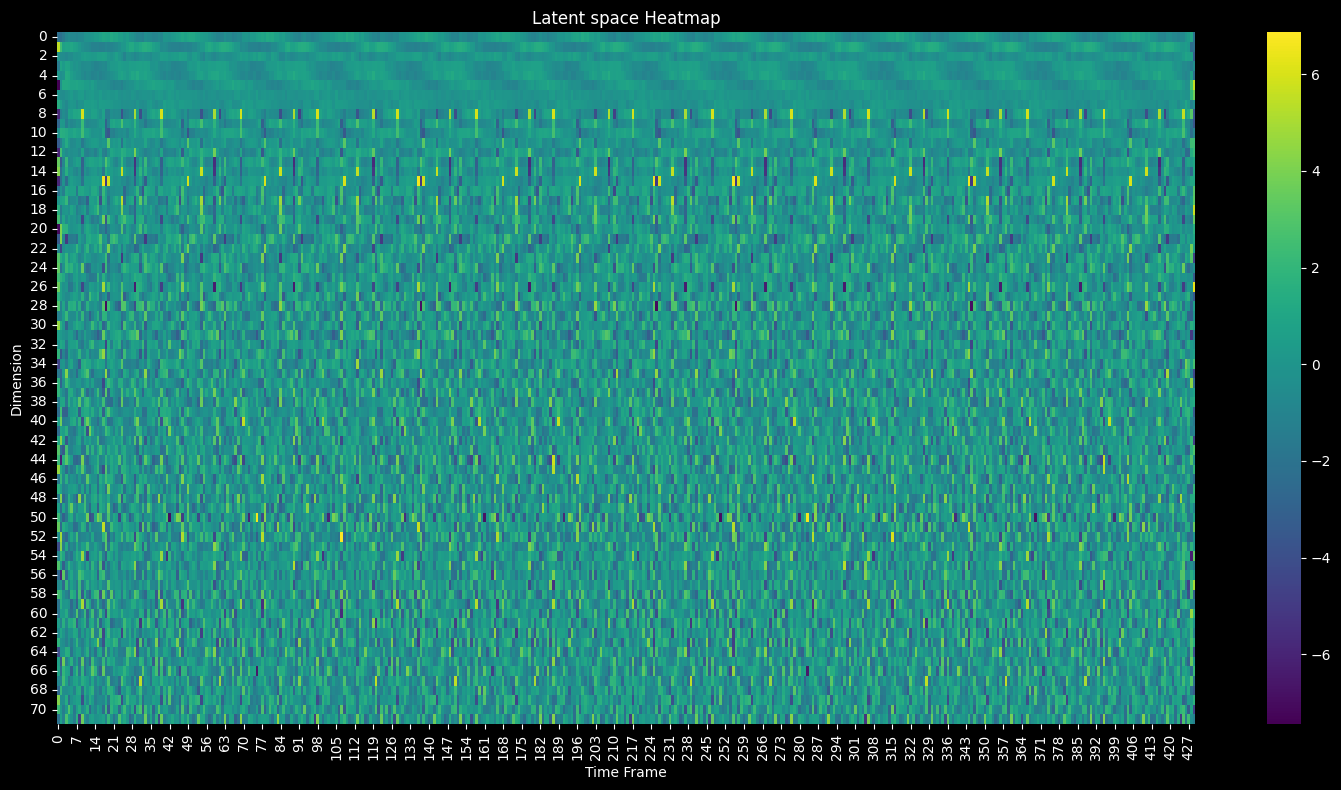

In [108]:
spectral_flux = snd_latents[:,:,1:] - snd_latents[:,:,:-1]

utils.plot_heatmap(spectral_flux)

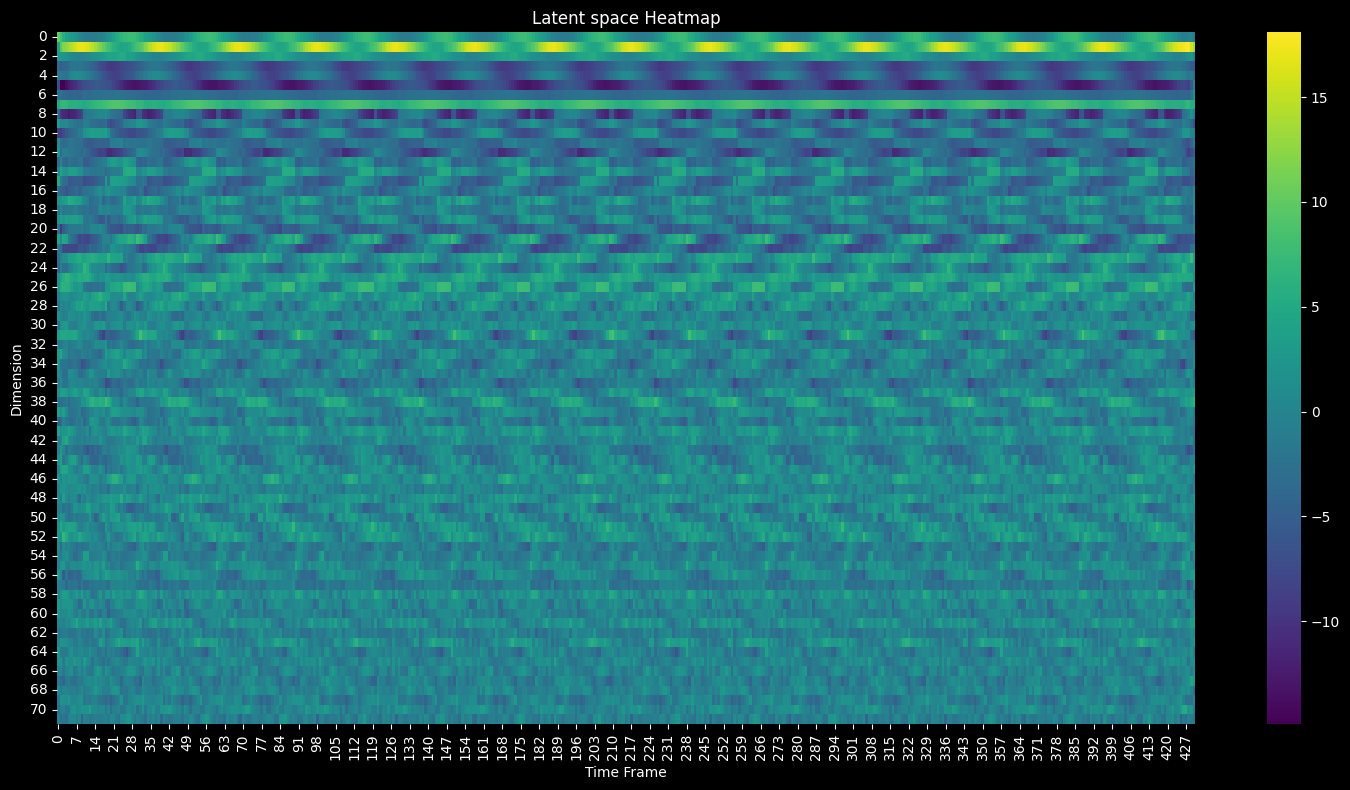

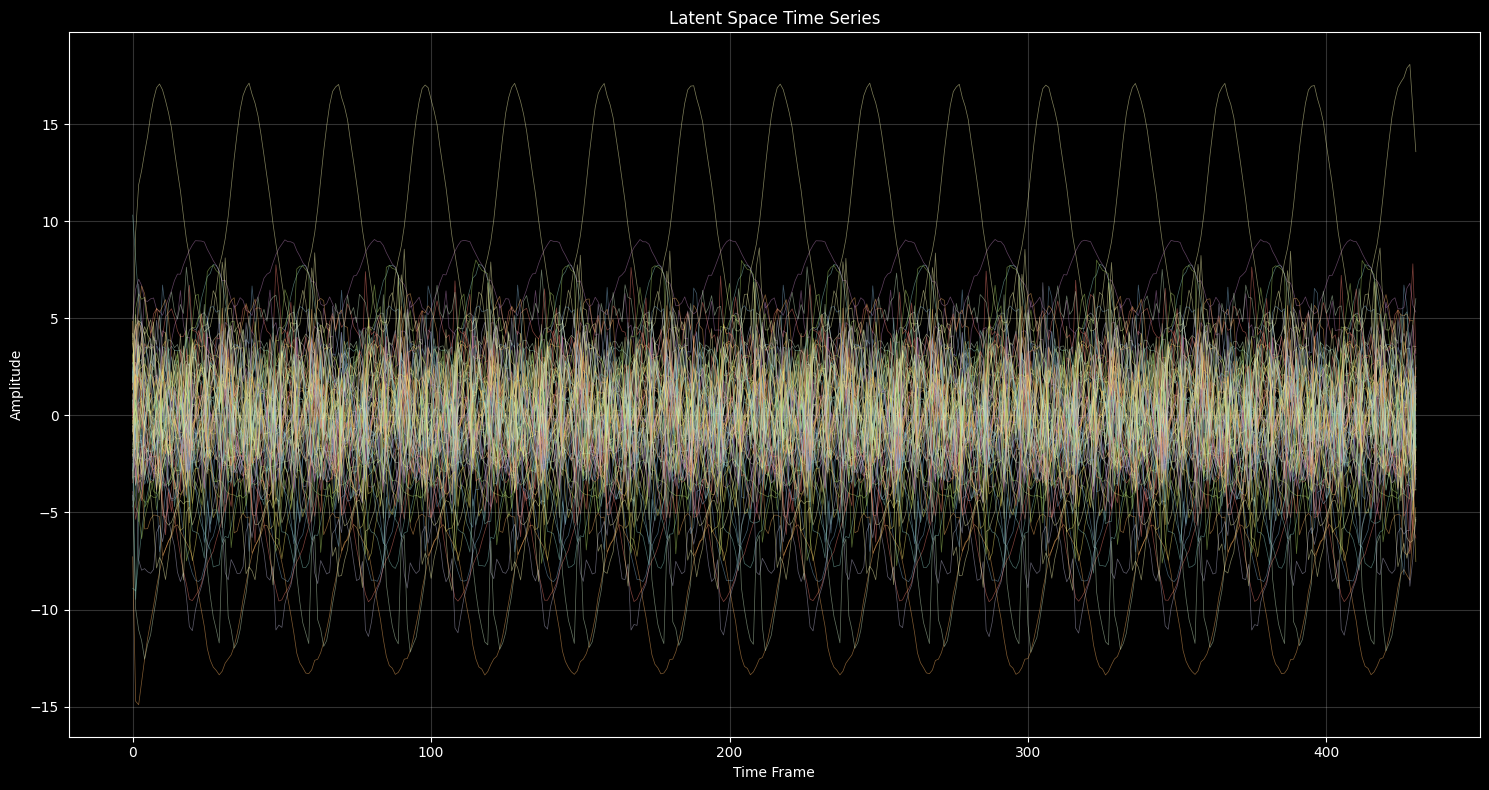

In [109]:
utils.plot_heatmap(snd_latents)
utils.plot_lines(snd_latents)



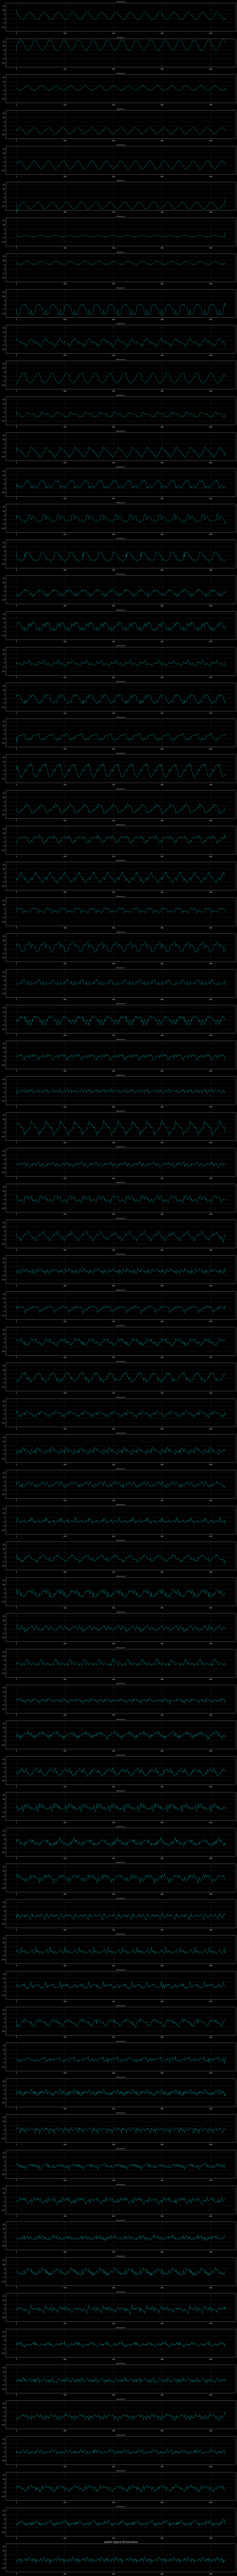

In [110]:
utils.plot_lines_separated(snd_latents)

In [111]:
snd_zeros = torch.zeros_like(snd_latents)
snd_zeros[:,0,] = snd_latents[:,0,:]

with torch.no_grad():
    snd_z,_a,_b = model.quantizer.from_latents(snd_zeros)
    audio_zeros = model.decode(snd_z)[0,0,:].cpu().detach().numpy()

display(Audio(audio_zeros, rate=sr))

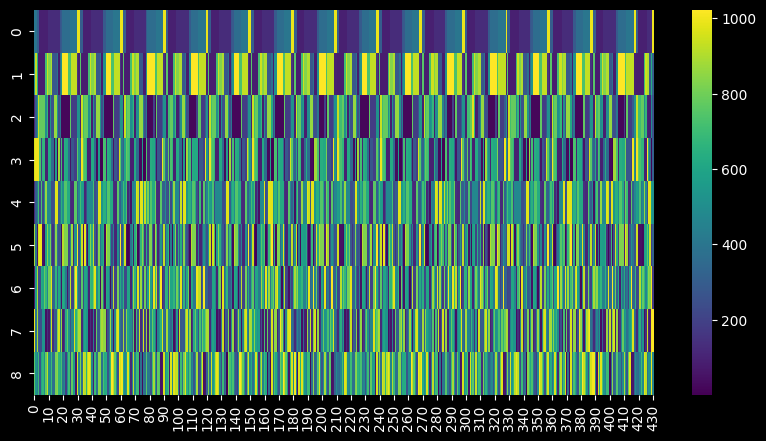

In [112]:
# spectrogam of codebooks
plt.figure(figsize=(10, 5))
sns.heatmap(snd_codes.cpu().numpy()[0,:,:], cmap='viridis')
plt.show()


In [113]:
with torch.no_grad():
    snd_reconstructed = model.decode(snd_z)

snd_reconstructed = snd_reconstructed[0,0,:].cpu().detach().numpy()

display(Audio(snd_reconstructed, rate=sr))

with torch.no_grad():
    snd_reordered_reconstructed = model.decode(reordered_snd_z)

snd_reordered_reconstructed = snd_reordered_reconstructed[0,0,:].cpu().detach().numpy()

display(Audio(snd_reordered_reconstructed, rate=sr))

In [114]:
with torch.no_grad():
    snd_reordered_reconstructed = model.decode(reordered_snd_z)

snd_reordered_reconstructed = snd_reordered_reconstructed[0,0,:].cpu().detach().numpy()

display(Audio(snd_reordered_reconstructed, rate=sr))